<a href="https://colab.research.google.com/github/elka97/GB_NN/blob/main/homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Содержание методического пособия:


<ol>
<li>Что такое Сверточные нейронные сети</li>
<li>Архитектура Сверточных нейронных сетей</li>
<li>Несколько практических примеров сверточных нейронных сетей на Keras</li>
</ol>

## Что такое Сверточные нейронные сети

Сверточные нейронные сети - это нейронные сети приспособленные впервую очередь для задач распознования образов. В их основе лежат работы в области изучения зрительной коры головного мозга. Их отличительная черта - добавление сверточных и пуллинговых слоев в архитектуру нейронной сети. Подробности архитектуры мы рассмотрим в следующей части данного методического пособия, а пока давайте взглянем на области применения данного вида нейронных сетей:

- Задачи связанные с определением того какому классу принадлежит объект на фотографии

- Сверточные нейронные сети в модифицированном виде могут определять не только что находиться на фотографии, но где находиться (этому виду нейронных сетей будет посвящен отдельный урок)

- Распознование лиц. В 2001 г. появился алгоритм Виолы-Джонса, который предложил технологию позволяющую технике находить лица на фотографиях и  в видеопотоке. На данный момент по эфективности этот алгоритм превзайден свертончными нейронными сетями.

- Проставление лейблов изображениям. Используется Google, Amazon, Facebook

- Визуальный поиск. Используется Google

- Рекомендательные системы. Amazon например, использует это для секции "вам также может понравиться" для одежды.

- В социальных сетях, с помощью них отмечаются люди на фотографиях

- Помощь врачам в анализе медицинских снимков

- Предиктивная аналитика. Помощь в предсказании проблем со здоровьем

- Оценка цифр написанных от руки банками. Одно из самых ранних применений сверточных нейронных сетей.

Однако применение сверточных нейронных сетей не ограничивается областью компьютерного зрения. Они также применяются и в других областях:

- Анализ текстов. Для этого больше подходят рекуррентные нейронные сети, но когда речь заходит о детекции определенных признаков в тексте например бранной речи, лучше могут подойти сверточные нейронные сети

- Предиктивный анализ. В частности предсказание погоды.


## Глубокое обучение

![full_connected.png](attachment:full_connected.png)

Источник изображения - https://camo.githubusercontent.com/920e95dc71acebe014549c9288cbf42cbe5c8afc/68747470733a2f2f6861726973686e61726179616e616e2e6f72672f696d616765732f77726974696e672f61727469737469632d7374796c652d7472616e736665722f726570726573656e746174696f6e2d6c6561726e696e672e706e67



Глубокое обучение - это обучение глубоких нейронных сетей. Глубокие нейронные сети - это сети с больше чем одним внутренним слоем.

Однако, прежде чем мы начнем разбирать глубокое обучение давайте в кратце опишем сверточные нейронные сети. Типичная сверточная нейронная сеть состоит из входного слоя и череды сверточных и пуллинговых слоев, следующих как правило друг за другом и нескольких полносвязных слоев на выходе.

Давайте попробуем разобраться в смысле данной архитектуры и как она связана с глубоким обучением. В отношение нейронных сетей известно, что нейронная сеть в один слой может лишить любую задачу. Но такой подход будет очень грубым решением проблемы и вычислительной мощности современных компьютеров не хватит, чтобы нейронная сеть в один слой например могла различать классы объектов на фотографии. 

Данная диллема решается через другой научный факт известный в отношении нейронных сетей - чем больше слоев тем эффективнее нейросеть. Т.е. строя многослойную нейронную сеть может понадобиться меньше нейронов чем если строить однослойную. Связано это с тем, что каждый слой выучивает признаки на определенном уровне абстракции и следующии за ним слои используют уже имеющиеся признаки, а не выучивают их заново.

Давайте в общих чертах посмотрим на то, как происходит процесс обучение в глубокой нейронной сети, поскольку такой же процесс в общих чертах будет характерен и для сверточных нейронных сетей.

Допустим мы будем работать с изображениями животных. Первые слои выучат признаки животных низкого уровня абстракции такие как линии под определенными углами, следующие слои на базе этих признаков выучат более сложные признаки, например геом. фигуры на базе сочетания этих линий. Следующие слои выучат такие признаки как глаза, уши и т.д. которые будут составлены из этих геометрических фигур. Подобные высокоасбтрактные признаки как названнные выше уже можно использовать для того чтобы сделать заключение какое животное на картинке.

Описанная система лучше с точки зрения вычислительных затрат. Однако если мы сделаем несколько полносвязных слоев где каждый нейрон связан с каждым нейроном другого слоя, то на обсчитывание этих связей уйдет меньше вычисл. ресурсов чем если бы нейронная сеть была в один слой, но всеравно такая нейронная сеть в не учебных задачах будет обучаться неприемлимо долго. 


## Архитектура Сверточных нейронных сетей

![lenet.png](attachment:lenet.png)
Источник - http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

Сверточные нейронные сети - это самый природо-подобный алгоритм из всех. Современные сверточные нейронные сети базируется на произведшей революцию в комп. зрении нейронной сети AlexNet, она базируется на сверточных нейронных сетях, которые разрабатывал Ян Лекун в 90 гг., те в свою очередь базируется на японском Neocognitron 1980 г., а он свою очередь на открытиях в области зрительной коры головного мозга. Конечно современные архитектуры сверточных нейронных сетей такие Inception-v4 сильно отличаются от сверточных нейронных сетей 90-x. Однако у них есть общие черты, которые и делают сверточные нейронные сети эффективными. Особенности сверточных нейронных сетей о которых речь пойдет далее призваны помочь строить глубокие нейронные сети, имеющими меньшие вычислительные затраты чем полносвязные. 

Главная отличительная черта сверточных нейронных сетей - это наличие сверточных слоев и пуллинг слоев. Подобные слои как раз и были обнаружены в зрительной коре головного мозга, но они называны по другому и работают конечно более сложным образом. В искусственной нейронной сети сверточный слой состоит из фрагментов, которые связаны только с определенной частью изображения, что позволяет не связывать каждый нейрон с каждым пикселем и уменьшить вычислительные затраты. Конечная цель сверточного слоя получить определенные признаки от изображения и передать их в следующий слой, точно также как и случае с обычной полнозсвязной нейронной сетью. Но сверточный слой это делает более эффективно. Если говорить упрощенно, то сама операция свертки предствляет из себя процесс преобразования большего набора чисел в меньший набор чисел их репрезентующий. Пуллинг слои следуют за сверточными слоями и призваны очистить от лишней информации эти признаки и убрать у них локальную привязку. Сама операция пуллинга если говорить опять же упрощенно представляет из себя процесс отбрасывания менее значимых сигналов представленных в виде чисел. Пулинг слои являются важной состовляющей нейронных сетей, однако из-за них сверточной нейронной сети всеравно где располагаются глаза например у кота над носом или под носом, главное сочетание этих признаков.

Сверточная нейронная сеть строиться по принципу пирамиды - первые слои содержат больше нейронов, а последующие все меньше и меньше. Связано это с тем что низкоабстрактных признаков больше чем высокоабстрактных.

Как правило на конце нейронной сети располагаются несколько полносвязных слоев. Эти слои как раз уже учатся на высокоабстрактных признаках которых немного и соотвественно не требуется много слоев и соотвесвенно с точки зрения вычислительных затрат они приемлимы. Т.е. получается сверточную нейронную сеть можно условно поделить на две части - одна извлекается признаки, а другая, полносвязная обучается на этих признаках.

Однако стоит отметить, что современные сверточные нейронные сети в целях оптимизации их работы снабжаются многим дополнительными архитектурными решениями, такими например как возможность иметь в одном слое разные конфигурации свертки, пропускать при необходимости сигнал обратного распространения ошибки сквозь слои, использование нескольких слоев свертки подряд, неиспользование полносвязных слоев на конце нейронных сетей. Как правило, все эти нововведения направлены на то чтобы сделать нейронные сети более глубокими, что в свою очередь улучшает точность работы нейронных сетей. 





In [ ]:
# Requires the latest pip
#!pip install --upgrade pip

# Current stable release for CPU and GPU
#!pip install tensorflow

# Or try the preview build (unstable)
#!pip install tf-nightly

In [ ]:
import cv2
import numpy as np
from scipy import misc
I = misc.ascent()

In [ ]:
I.shape

(512, 512)

In [ ]:
I[101:131,120:130]

array([[ 98, 100, 101, 102, 101, 102, 101,  89,  83,  88],
       [100, 103, 102, 102, 101,  92,  81,  89,  92,  82],
       [102, 103, 101,  94,  86,  87,  98,  82,  67,  84],
       [103,  96,  85,  88,  98,  90,  63,  58,  88,  97],
       [ 90,  92,  99,  92,  67,  49,  63,  93,  97,  95],
       [ 98,  92,  68,  51,  64,  90, 100,  97,  98,  99],
       [ 71,  48,  63,  88, 102, 101,  97,  97,  98,  98],
       [ 64,  85, 102, 104,  97,  95,  97,  98,  97,  98],
       [ 99, 103, 101, 100,  97,  98,  98,  97,  98,  97],
       [ 98, 101,  99,  99,  97,  97,  97,  98,  97,  98],
       [100, 100,  99,  97,  97,  97,  98,  97,  97,  99],
       [101, 100,  99,  97,  99, 100,  99,  97,  97,  98],
       [101, 101,  98,  98,  99, 101,  98,  98,  98,  98],
       [100,  99, 102, 100,  99,  97,  97,  98, 100, 100],
       [100,  99, 101, 101,  99,  98,  98,  99, 101, 100],
       [101, 101, 100, 101, 101, 101, 101, 101, 100, 101],
       [101, 101, 100,  99, 100, 101, 100, 101, 101,  99

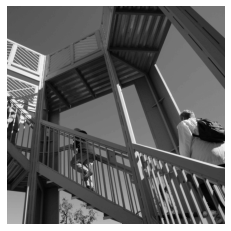

In [ ]:
import matplotlib.pyplot as plt
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
I_transformed = np.copy(I)
size_x = I_transformed.shape[0]
size_y = I_transformed.shape[1]

In [ ]:
filter = np.array([ [1, 1, 1], [1, 1, 1], [1, 1, 1]])/9
# Фильтры края.

#Разные фильтры.
filter = [ [0, 1, 0], [1, -4, 1], [0, 1, 0]]
#filter = np.random.randn(3,3)

# Много разных
#filter = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]]
#filter = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

# зададим вес для свертки
weight  = 1

In [ ]:
np.array(filter).shape

(3, 3)

In [ ]:
np.array(filter).T

array([[ 0,  1,  0],
       [ 1, -4,  1],
       [ 0,  1,  0]])

### Свертка

In [ ]:
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0
      convolution = convolution + (I[x - 1, y-1] * filter[0][0])
      convolution = convolution + (I[x, y-1] * filter[0][1])
      convolution = convolution + (I[x + 1, y-1] * filter[0][2])
      convolution = convolution + (I[x-1, y] * filter[1][0])
      convolution = convolution + (I[x, y] * filter[1][1])
      convolution = convolution + (I[x+1, y] * filter[1][2])
      convolution = convolution + (I[x-1, y+1] * filter[2][0])
      convolution = convolution + (I[x, y+1] * filter[2][1])
      convolution = convolution + (I[x+1, y+1] * filter[2][2])
      convolution = convolution * weight
      if(convolution<0):
        convolution=-convolution
      if(convolution>255):
        convolution=255
      I_transformed[x, y] = convolution

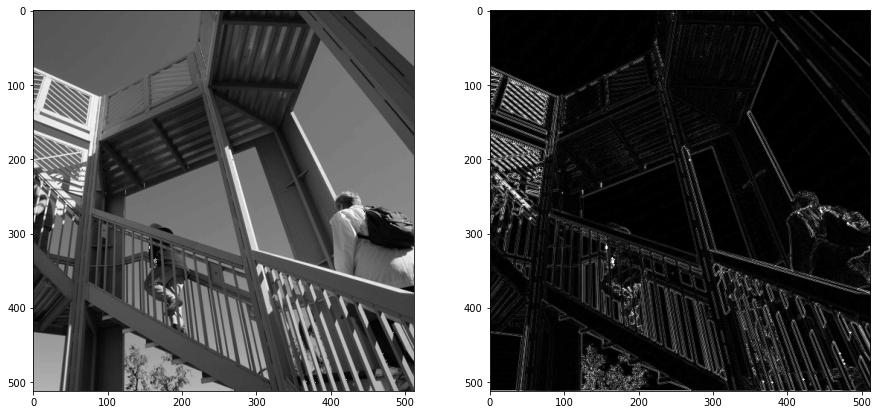

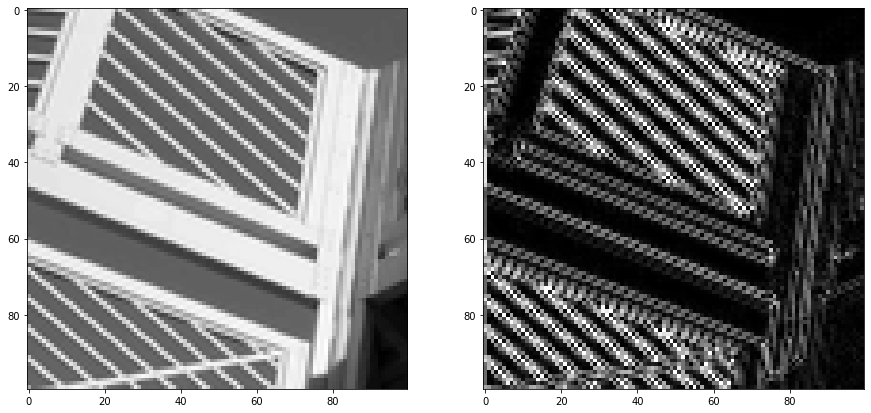

In [ ]:
# Plot the image. 512 by 512
plt.figure(figsize=(15,7))
plt.gray()
plt.grid(False)
plt.subplot(1,2,1)
plt.imshow(I)
plt.subplot(1,2,2)
plt.imshow(I_transformed)
#plt.axis('off')
plt.show()

ymin,ymax,xmin,xmax = 100,200,0,100

plt.figure(figsize=(15,7))
plt.gray()
plt.grid(False)
plt.subplot(1,2,1)
plt.imshow(I[ymin:ymax,xmin:xmax])
plt.subplot(1,2,2)
plt.imshow(I_transformed[ymin:ymax,xmin:xmax])
#plt.axis('off')
plt.show() 

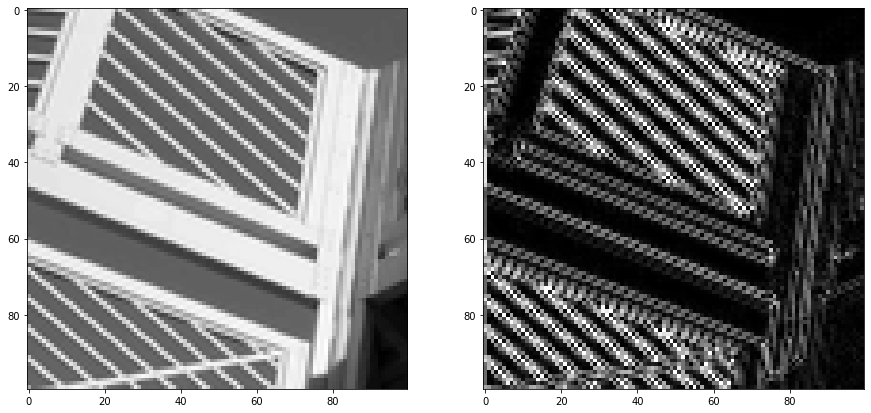

In [ ]:
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0

      dI = I[x-1:x+2, y-1: y +2] 
      convolution =np.sum(dI * filter)

      convolution = convolution * weight
      if(convolution<0):
        convolution=- convolution
      if(convolution>255):
        convolution=255
      I_transformed[x, y] = convolution


ymin,ymax,xmin,xmax = 100,200,0,100

plt.figure(figsize=(15,7))
plt.gray()
plt.grid(False)
plt.subplot(1,2,1)
plt.imshow(I[ymin:ymax,xmin:xmax])
plt.subplot(1,2,2)
plt.imshow(I_transformed[ymin:ymax,xmin:xmax])
#plt.axis('off')
plt.show()

https://setosa.io/ev/image-kernels/

визуализация фильтров

### Pooling

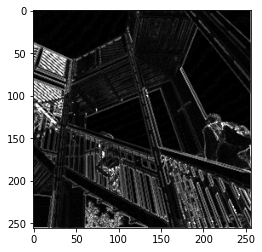

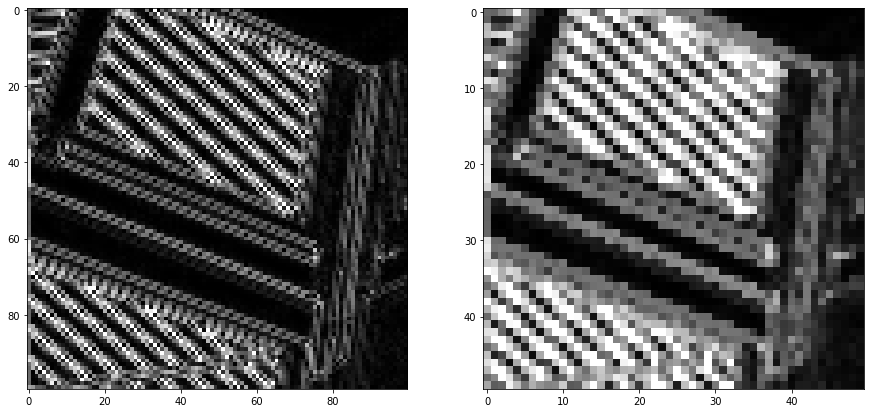

In [ ]:
new_x = int(size_x/2)
new_y = int(size_y/2)
newImage = np.zeros((new_x, new_y))
for x in range(0, size_x, 2):
  for y in range(0, size_y, 2):
    pixels = []
    pixels.append(I_transformed[x, y])
    pixels.append(I_transformed[x+1, y])
    pixels.append(I_transformed[x, y+1])
    pixels.append(I_transformed[x+1, y+1])
    newImage[int(x/2),int(y/2)] = np.max(pixels)

# Plot the image. Note the size of the axes -- now 256 pixels instead of 512
plt.gray()
plt.grid(False)
plt.imshow(newImage)
#plt.axis('off')
plt.show()

ymin,ymax,xmin,xmax = 100,200,0,100

plt.figure(figsize=(15,7))
plt.gray()
plt.grid(False)
plt.subplot(1,2,1)
plt.imshow(I_transformed[ymin:ymax,xmin:xmax])
plt.subplot(1,2,2)
plt.imshow(newImage[ymin//2:ymax//2,xmin//2:xmax//2])

#plt.axis('off')
plt.show()

## Пример создания сверточных и пуллинг слоев на Keras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 


from tensorflow.keras.utils import plot_model 

In [ ]:

# определение входных данных(8 массивов с 8 элементами)
data = [[0, 0, 0, 1, 1, 0, 0, 0],
		[0, 0, 0, 1, 1, 0, 0, 0],
		[0, 1, 0, 1, 1, 0, 0, 0],
		[0, 0, 0, 1, 1, 0, 0, 0],
		[0, 0, 0, 1, 1, 0, 0, 0],
		[0, 0, 0, 1, 1, 0, 0, 0],
		[0, 0, 0, 1, 1, 0, 0, 1],
		[0, 0, 0, 1, 1, 0, 0, 0]]

data = np.array(data)
data = data.reshape(1, 8, 8, 1)

# создание модели
x_input = Input(shape=(8,8,1))
x_conv = Conv2D( 1,  (3,3),  strides=(1,1)  , activation='relu',padding='same')(x_input)#
x_pool =  MaxPooling2D()(x_conv)

model = Model(x_input,x_pool)
model_conv = Model(x_input,x_conv)

# вывод описания созданной модели
model.summary()



Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 1)           10        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 1)          0         
 2D)                                                             
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


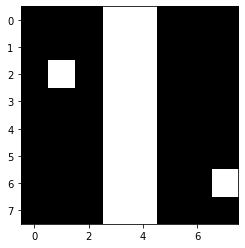

In [ ]:
plt.imshow(data[0,:,:,0])
plt.show()

In [ ]:
hh = model.layers[-2]
hh

In [ ]:
w_old = model.layers[-2].get_weights()
w_old

[array([[[[-0.49269694]],
 
         [[-0.43005085]],
 
         [[ 0.19752276]]],
 
 
        [[[ 0.08970565]],
 
         [[ 0.25599015]],
 
         [[-0.48340234]]],
 
 
        [[[-0.12295127]],
 
         [[ 0.5385971 ]],
 
         [[-0.51127857]]]], dtype=float32), array([0.], dtype=float32)]

In [ ]:
w_old[0].shape

(3, 3, 1, 1)

In [ ]:
# определение дектора вертикальной линии
detector = [[[[0]],[[1]],[[0]]],
            [[[0]],[[1]],[[0]]],
            [[[0]],[[1]],[[0]]]]
weights = [np.array(detector), np.array([0.0])]

# сохранение весов в модель
model.set_weights(weights)

# применение фильтра к входным данным
ypool = model.predict(data )

print(ypool[0].T)


[[[1. 1. 0. 0.]
  [3. 3. 3. 3.]
  [3. 3. 3. 3.]
  [0. 0. 1. 1.]]]


In [ ]:
y_conv = model_conv.predict(data)
print('Входной тензор')
print(data[0].T)
print('Результат свертки')
print(y_conv[0].T)

print('размерность входа',data.shape)
print('размерность входа',y_conv.shape)

Входной тензор
[[[0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0]]]
Результат свертки
[[[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [2. 3. 3. 3. 3. 3. 3. 2.]
  [2. 3. 3. 3. 3. 3. 3. 2.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 1. 1.]]]
размерность входа (1, 8, 8, 1)
размерность входа (1, 8, 8, 1)


In [ ]:
y_conv = model_conv.predict(data)
print('Входной тензор')
print(data[0].T)
print('Результат свертки')
print(y_conv[0].T)

print('размерность входа',data.shape)
print('размерность выхода свертки',y_conv.shape)

print('Результат пулинга')
print(ypool[0].T)
print('размерность выхода пулинга',ypool.shape)

Входной тензор
[[[0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0]]]
Результат свертки
[[[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [2. 3. 3. 3. 3. 3. 3. 2.]
  [2. 3. 3. 3. 3. 3. 3. 2.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 1. 1.]]]
размерность входа (1, 8, 8, 1)
размерность выхода свертки (1, 8, 8, 1)
Результат пулинга
[[[1. 1. 0. 0.]
  [3. 3. 3. 3.]
  [3. 3. 3. 3.]
  [0. 0. 1. 1.]]]
размерность выхода пулинга (1, 4, 4, 1)


In [ ]:
# создание модели
x_input = Input(shape=(512,512,1))
x_conv = Conv2D(1, (3,3), activation='relu',padding='same')(x_input)
pool_kernel = 8
strade = pool_kernel
x_pool = MaxPooling2D( pool_size=(pool_kernel,pool_kernel), strides=strade)(x_conv)

model1 = Model(x_input,x_pool)
model_conv1 = Model(x_input,x_conv)



# определение дектора вертикальной линии
detector = [[[[1]],[[-1]],[[-1]]],
            [[[1]],[[-1]],[[-1]]],
            [[[1]],[[-1]],[[-1]]]]
weights = [np.array(detector), np.array([0.0])]

model1.set_weights(weights)

# вывод описания созданной модели
model1.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 512, 512, 1)       10        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 1)        0         
 2D)                                                             
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Входной тензор


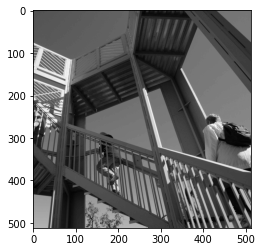

Результат свертки


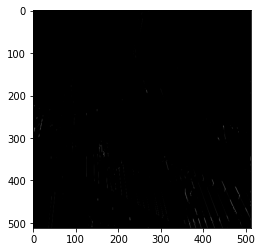

размерность входа (512, 512)
размерность выхода свертки (1, 512, 512, 1)
Результат пулинга


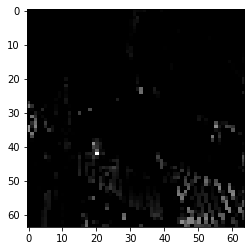

размерность выхода пулинга (1, 64, 64, 1)


In [ ]:

y_conv1 = model_conv1.predict(I.reshape((1,512,512,1))/255)
y_pool1 = model1.predict(I.reshape((1,512,512,1))/255)
print('Входной тензор')

plt.imshow(I)
plt.show()
print('Результат свертки')
x1 = 0
y1 = 0
plt.imshow(y_conv1[0,x1:,y1:,0]/y_conv1[0].max())
plt.show()

print('размерность входа',I.shape)
print('размерность выхода свертки',y_conv1.shape)

print('Результат пулинга')
x1p = x1 // strade
y1p = y1 // strade
plt.imshow(y_pool1[0,y1p:,x1p:,0]/y_pool1[0].max())
plt.show()
print('размерность выхода пулинга',y_pool1.shape)

 Немного экзотики:

 разбор картинки на части:

In [ ]:
patch1 = tf.image.extract_patches(images=I.reshape((1,512,512,1)),
                           sizes=[1, 3, 3, 1],
                           strides=[1, 10, 10, 1],
                           rates=[1, 2, 2, 1],
                           padding='SAME')
patch2 = tf.image.extract_glimpse(I.reshape((1,512,512,1)), size=(100, 100), offsets=[[100, 100]],
                        centered=False, normalized=False)

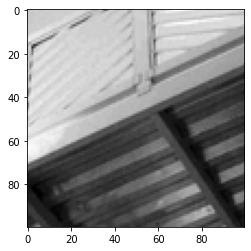

In [ ]:
plt.imshow(patch2[0,:,:,0])
plt.show()

(1, 52, 52, 9)


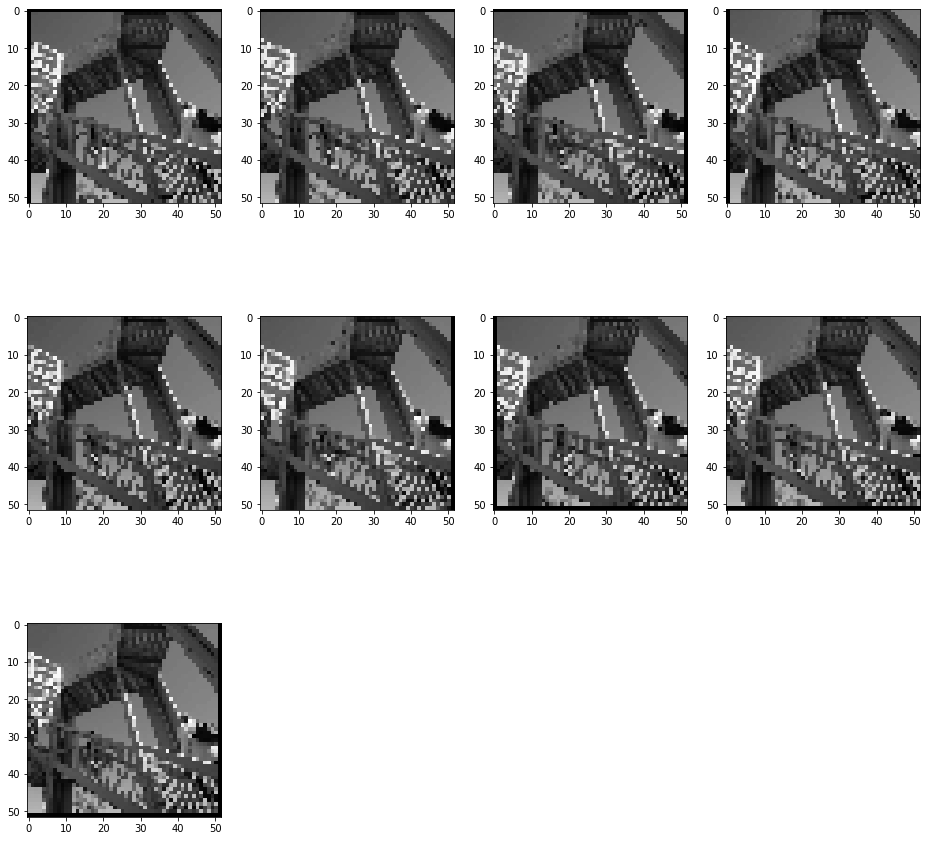

In [ ]:
print(patch1.shape)
plt.figure(figsize = (16,16))
for i in range(patch1.shape[-1]):
  plt.subplot(3,patch1.shape[-1] // 3+1,i+1)
  plt.imshow(patch1[0,:,:,i])
plt.show()

Преобразования: 
FFT - через TF

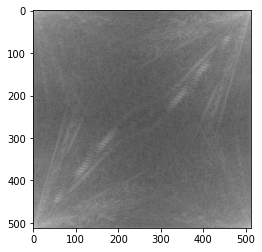

In [ ]:
fft_img = tf.signal.fft3d(I.reshape((1,512,512,1)))

plt.imshow(tf.math.log(tf.math.abs(fft_img)).numpy()[0,:,:,0])
plt.show()

## Нейронная сеть Lenet5.

Lenet5 - это одна из первых сверточных нейронных сетей и она отражает характерные для сверточных нейронных сетей набор элементов - сверточные слои, пуллинг слои и полносвязные слои на конце нейронной сети. Данная архитектура послужила основой для многих современных архитектур сверточных нейронных сетей.

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
import tensorflow.keras as keras

# инициализация пустой модели
model = Sequential()

# первый сверточный слой
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding="same"))

# второй пуллинговый слой
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

# третий сверточный слой
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# четвертый пуллинговый слой
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# пятый полносвязный слой
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
model.add(layers.Flatten())

# шестой полносвязный слой
model.add(layers.Dense(84, activation='tanh'))

# выходной слой с функцией активации softmax
model.add(layers.Dense(10, activation='softmax'))


# компилияция модели
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])


hist = model.fit(x=x_train,y=y_train, epochs=2, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))




11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/2
469/469 [==============================] - 8s 14ms/step - loss: 0.6562 - accuracy: 0.8337 - val_loss: 0.3312 - val_accuracy: 0.9095
Epoch 2/2
313/313 [==============================] - 1s 4ms/step - loss: 0.2564 - accuracy: 0.9271
Test loss 0.2564, accuracy 92.71%


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 27, 27, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_9 (Conv2D)           (None, 23, 23, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 11, 11, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 5880)              0

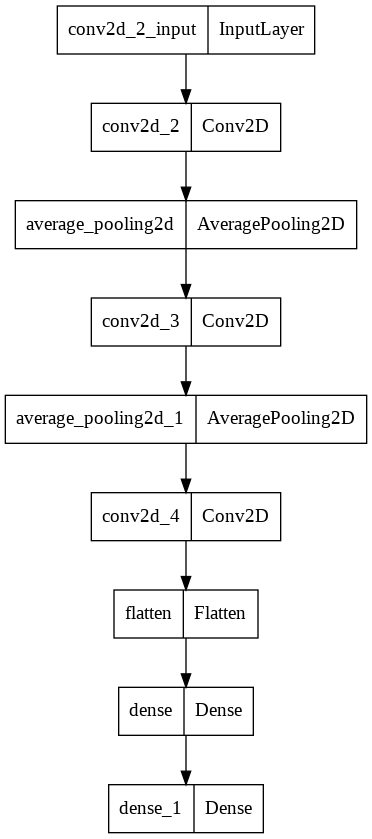

In [ ]:
plot_model(model,'model_sconv.png')

In [ ]:
y_pred=model.predict(x_test)

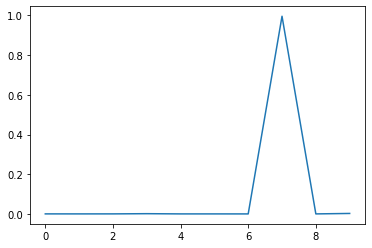

[1.6106352e-04 1.0413165e-04 1.9865223e-04 1.1956181e-03 9.4755094e-05
 9.1572256e-05 3.0836482e-06 9.9571627e-01 8.5567292e-05 2.3493278e-03]


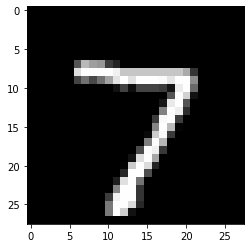

In [ ]:
plt.plot(y_pred[0][:])
plt.show()
print(y_pred[0][:])
plt.imshow(x_test[0][:,:,0])
plt.show()

Построим примерно такую же сеть через функцианальное описание

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Model 
# инициализация  модели
input1= layers.Input(shape=(28,28,1))
# первый сверточный слой
x1 = layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh',  padding="same")(input1)

# второй пуллинговый слой
x2 = layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x1)

# третий сверточный слой
x3 = layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid')(x2)

# четвертый пуллинговый слой
x4 = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x3)

# пятый  слой
x5 = layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid')(x4)

# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
x6 = layers.Flatten()(x5)

# шестой полносвязный слой
x7 = layers.Dense(84, activation='tanh')(x6)

# выходной слой с функцией активации softmax
out_x = layers.Dense(10, activation='softmax')(x7)


# Соберем полную модель сети от входа к выходу 
model1 = Model(inputs = input1, outputs = out_x) 
# сделаем несколько промежуточных выходов (через них посмотрим , что происходит в сети) 
model3 = Model(inputs = input1, outputs = x3)
model5 = Model(inputs = input1, outputs = x5)
# компилияция модели
model1.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

# Обучаем модель
hist = model1.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model1.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

Epoch 1/10
469/469 [==============================] - 7s 13ms/step - loss: 0.9238 - accuracy: 0.6933 - val_loss: 0.6579 - val_accuracy: 0.7592
Epoch 2/10
469/469 [==============================] - 5s 12ms/step - loss: 0.5870 - accuracy: 0.7826 - val_loss: 0.5834 - val_accuracy: 0.7848
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.5280 - accuracy: 0.8080 - val_loss: 0.5412 - val_accuracy: 0.8019
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.4925 - accuracy: 0.8238 - val_loss: 0.5147 - val_accuracy: 0.8130
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.4664 - accuracy: 0.8345 - val_loss: 0.4877 - val_accuracy: 0.8244
Epoch 6/10
469/469 [==============================] - 5s 11ms/step - loss: 0.4456 - accuracy: 0.8439 - val_loss: 0.4676 - val_accuracy: 0.8359
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - loss: 0.4285 - accuracy: 0.8493 - val_loss: 0.4510 - val_accuracy: 0.8436

Сделаем предикт для примеров тестов

In [ ]:
y_pred=model1.predict(x_test)

Подглядываем в третий сверточный слой

In [ ]:
b = model3.predict(x_test)



Подглядываем в пятый слой

In [ ]:
b1 = model5.predict(x_test)

Содержание внутреннего слоя 

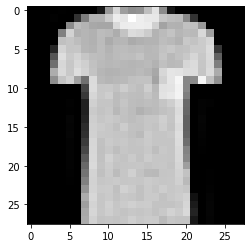

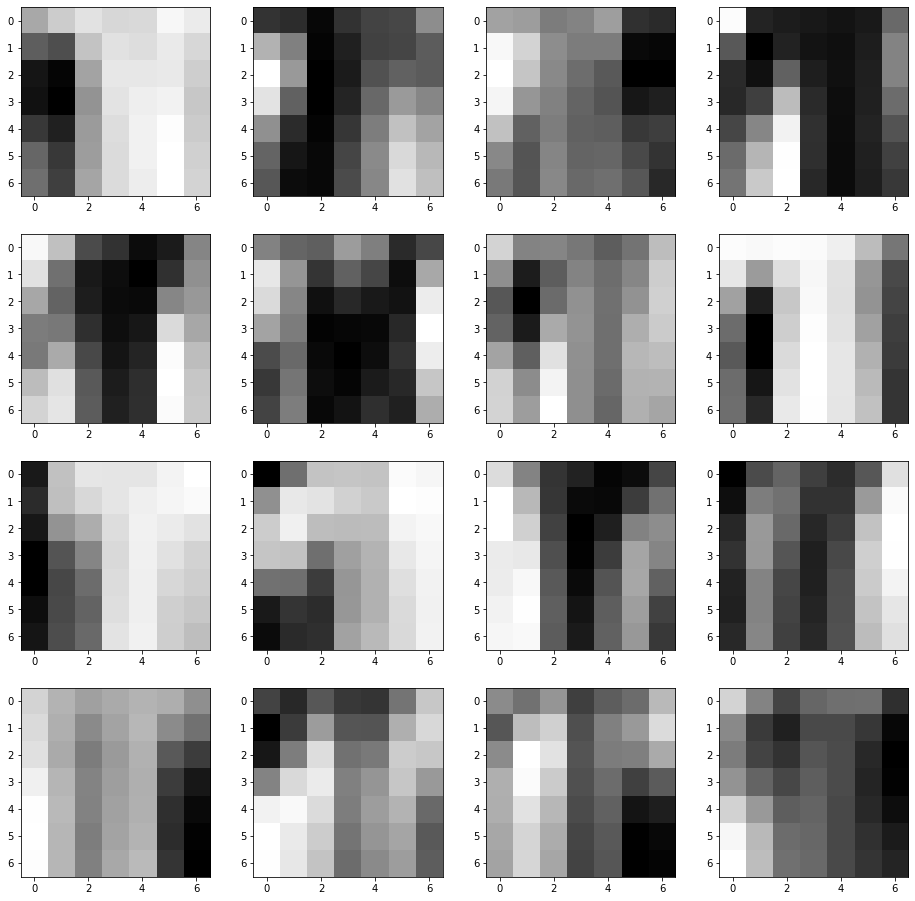

In [ ]:
n = 501
plt.imshow(x_test[n,:,:,0])
plt.show()

plt.figure(figsize=(16,16))
for i in range(4):
  for j in range(4):
    plt.subplot(4,4,i*4+j+1)
    plt.imshow(b1[n][:,:,i*4+j])
plt.show()

Сделаем ссылку для обращения к слою

In [ ]:
wg = model5.get_layer(index = -1)

Получим веса слоя

In [ ]:
w_ = wg.get_weights()

Размер ядер слоя

In [ ]:
w_[0].shape

(5, 5, 16, 120)

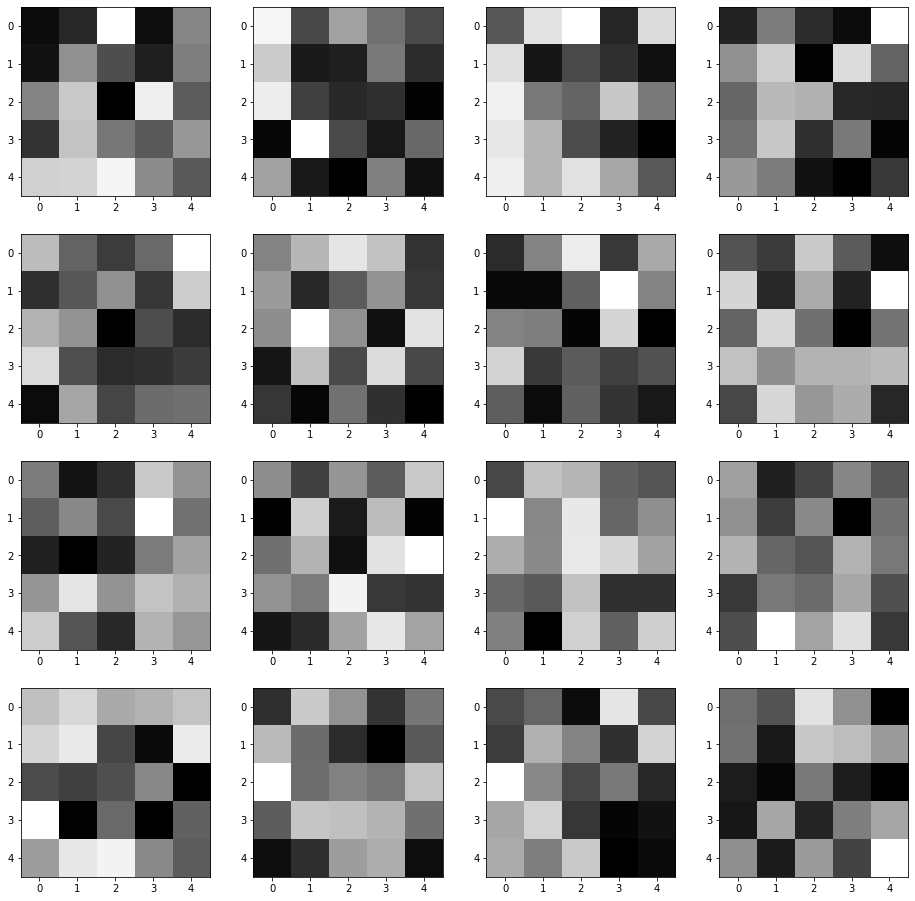

In [ ]:
plt.figure(figsize=(16,16))
for i in range(4):
  for j in range(4):
    plt.subplot(4,4,i*4+j+1)
    plt.imshow(np.abs(w_[0][:,:,i*4+j,0]))
plt.show()

In [ ]:
w_[0][:,:,3*4+3,0]

array([[ 0.02376761,  0.01819579, -0.04622228,  0.03013679, -0.00174023],
       [-0.02418316,  0.00663716, -0.04118775, -0.03908463,  0.03216051],
       [ 0.00729287,  0.00290889,  0.02574408,  0.0075401 ,  0.00165108],
       [ 0.00636177,  0.03445554, -0.00889902,  0.02687669,  0.03458771],
       [-0.0299683 ,  0.00703077, -0.0324466 ,  0.01506996,  0.052207  ]],
      dtype=float32)

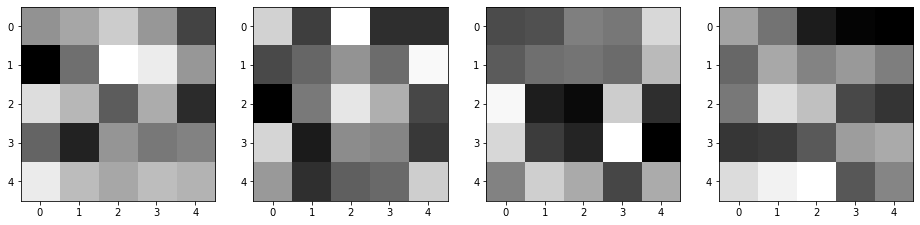

In [ ]:
plt.figure(figsize=(16,4))
for i in range(1):
  for j in range(4):
    plt.subplot(1,4,j+1)
    plt.imshow((w_[0][:,:,0,3*4+j]))
plt.show()

In [ ]:
model1.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 27, 27, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_12 (Conv2D)          (None, 23, 23, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 11, 11, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 120)         481



## **Сложные конструкции из простых слоев**

Слой для объединения

https://keras.io/api/layers/merging_layers/concatenate/

In [ ]:

from tensorflow.keras.layers import Dense, Flatten, Concatenate

from tensorflow.keras.utils import plot_model 


Строим сеть из трех нитей

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


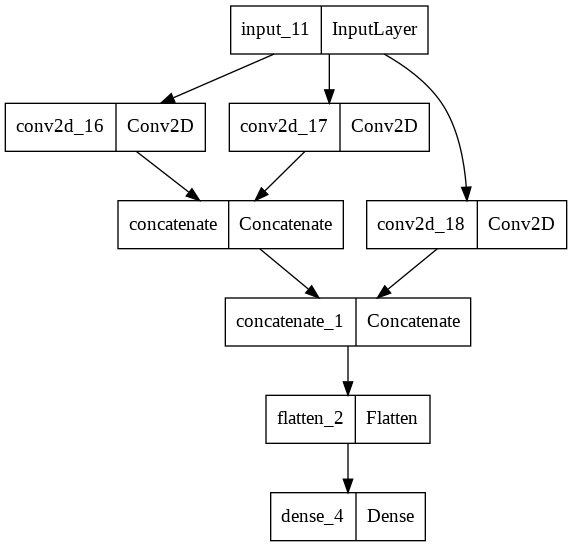

In [ ]:
first_input = Input(shape=(28,28,1 ))
x11= Conv2D(16,3,activation='relu',padding = 'same')(first_input)
#x11= Flatten()(x11)
first_dense = x11# Dense(10, )(x11)

#second_input = Input(shape=(28,28,1 ))
x22= Conv2D(16,5,activation='relu',padding = 'same')(first_input)
#x22= Flatten()(x22)
second_dense = x22 #Dense(10, )(x22)

merge_one = Concatenate(  axis =-1 )([first_dense, second_dense])

third_input = Input(shape=(28,28,1 ))
x33= Conv2D(16,1,activation='relu',padding = 'same')(first_input)
#x33= Flatten()(x33)
#x33 = Dense(10, )(x33)
merge_two1 = Concatenate(axis = -1)([merge_one, x33])
merge_two= Flatten()(merge_two1)
merge_two=Dense(10, activation='softmax')(merge_two)

model_stek = Model(inputs=first_input, outputs=merge_two)
#model_stek = Model(inputs=[first_input, second_input, third_input], outputs=merge_two)
ada_grad = tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
model_stek.compile(optimizer=ada_grad, loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


plot_model(model_stek,'model_stek.png')



In [ ]:
model_stek.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 28, 28, 16)   160         ['input_11[0][0]']               
                                                                                                  
 conv2d_17 (Conv2D)             (None, 28, 28, 16)   416         ['input_11[0][0]']               
                                                                                                  
 concatenate (Concatenate)      (None, 28, 28, 32)   0           ['conv2d_16[0][0]',              
                                                                  'conv2d_17[0][0]']       

In [ ]:
#hist = model_stek.fit([x_train,x_train,x_train],y_train, epochs = 5, validation_split=0.2)
hist = model_stek.fit(x_train,y_train, epochs = 5, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.4543 - accuracy: 0.8474 - val_loss: 0.3894 - val_accuracy: 0.8595
Epoch 2/5
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3047 - accuracy: 0.8917 - val_loss: 0.3164 - val_accuracy: 0.8873
Epoch 3/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2631 - accuracy: 0.9060 - val_loss: 0.2867 - val_accuracy: 0.8981
Epoch 4/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2374 - accuracy: 0.9154 - val_loss: 0.3046 - val_accuracy: 0.8928
Epoch 5/5
1500/1500 [==============================] - 11s 8ms/step - loss: 0.2155 - accuracy: 0.9226 - val_loss: 0.2780 - val_accuracy: 0.9045


## Пример на Keras более сложной сверточной нейронной сети

Давайте теперь попробуем сделать несколько усложненный вариант нейронной сети разобранной ранее. В ней будет на несколько слоев больше и в ней будет использоваться data augumentation, процедура позволяющая за счет искажений изображений увеличить количество тренировочных данных, а как мы знаем чем больше тренировочных данных тем лучше будет работать нейросеть. Для обучения нейросети будем использовать датасет cifar-10. В нем 10 категорий объектов, например - лошадь, лягушка, корабль. Данный датасет уже более сложен для нейронных сетей чем mnist, однако он намного проще датасетов наподобие imagenet где используются сотни классов и архитектуры нейронных сетей для подобных датасетов также понадобяться более сложные.

In [3]:
from __future__ import print_function
import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение

In [4]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [5]:
num_classes = len(classes)

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')


170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [6]:
# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
# установка параметров нейросети
batch_size = 32
epochs = 1
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [ ]:
data_augmentation = False

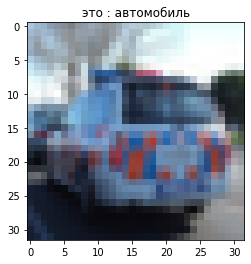

In [12]:
N = 1131

plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

In [13]:
# When using this layer as the first layer in a model,
# provide the keyword argument input_shape
# (tuple of integers or None, does not include the sample axis),
# e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures
# in data_format="channels_last". You can use None when
# a dimension has variable size.
x_train.shape[1:]

(32, 32, 3)

In [ ]:
# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(filters=32, kernel_size=11, strides=4, padding='valid', input_shape=x_train.shape[1:], activation='relu'))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])


In [ ]:
# # конфигурирование слоев нейросети
# model = Sequential()

# # слои нейросети отвественные за свертку и max-pooling
# model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout( 0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # полносвязные слои нейронной сети
# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

# # инициализация RMSprop optimizer
# #opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# # компиляция модели
# model.compile(loss='categorical_crossentropy',
#               optimizer='SGD',
#               metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
1563/1563 [==============================] - 24s 15ms/step - loss: 2.0678 - accuracy: 0.2356 - val_loss: 1.8307 - val_accuracy: 0.3360
сохранить обученную модель как /content/saved_models/keras_cifar10_trained_model.h5 
313/313 [==============================] - 2s 6ms/step - loss: 1.8307 - accuracy: 0.3360
Test loss: 1.8307493925094604
Test accuracy: 0.335999995470047


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                      

Что вернет ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip= False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

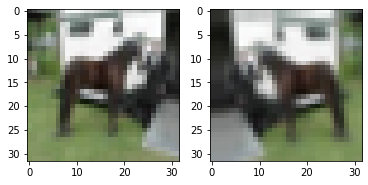

In [ ]:
N=20
datagen.fit(x_test)
for imag,y  in datagen.flow(x_test[N:N+1,:,:,:],y_test[N:N+1], batch_size=1):
  plt.subplot(1,2,1)
  plt.imshow(x_test[N][:,:,:])
  plt.subplot(1,2,2)
  plt.imshow(imag[0,:,:,:])

  plt.show()
  if True:
    break


In [ ]:
 model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


1563/1563 [==============================] - 48s 31ms/step - loss: 1.8001 - accuracy: 0.3437 - val_loss: 1.5932 - val_accuracy: 0.4230


In [ ]:
 model.fit(x_train, y_train,       batch_size=batch_size,epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 23s 15ms/step - loss: 1.5651 - accuracy: 0.4273 - val_loss: 1.5819 - val_accuracy: 0.4381
Epoch 2/5
1563/1563 [==============================] - 21s 14ms/step - loss: 1.4430 - accuracy: 0.4767 - val_loss: 1.2997 - val_accuracy: 0.5318
Epoch 3/5
1563/1563 [==============================] - 22s 14ms/step - loss: 1.3557 - accuracy: 0.5124 - val_loss: 1.2361 - val_accuracy: 0.5619
Epoch 4/5
1563/1563 [==============================] - 22s 14ms/step - loss: 1.2901 - accuracy: 0.5376 - val_loss: 1.1640 - val_accuracy: 0.5897
Epoch 5/5
1563/1563 [==============================] - 22s 14ms/step - loss: 1.2316 - accuracy: 0.5613 - val_loss: 1.1431 - val_accuracy: 0.5964


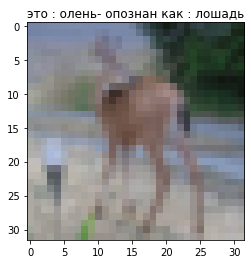

In [ ]:
N = 100
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

## Дополнительные материалы

<ol>
    <li>https://keras.io/layers/convolutional/</li>
    <li>https://keras.io/layers/pooling/</li>
    <li>https://keras.io/preprocessing/image/</li>
</ol>

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>https://keras.io</li>
    <li>Шакла Н. — Машинное обучение и TensorFlow 2019</li>
    <li>Николенко Сергей Игоревич, Кадурин А. А. - Глубокое обучение. Погружение в мир нейронных сетей  2018</li>
    <li>Francois Chollet - Deep Learning with Python 2018</li>
    <li>Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton - ImageNet Classification with Deep Convolutional Neural Networks</li>
    <li>Karen Simonyan, Andrew Zisserman - Very Deep Convolutional Networks for Large-Scale Image Recognition</li>
    <li>Википедия</li>    
</ol>

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
(x,y),(d,h) =imdb.load_data(path='imdb.npz')

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
h[:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [ ]:
y[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])